# Automatic Recognition of Peruvian Car License Plates



Integrantes:

-SEQUEIROS ORTIZ EDUARDO JAIME

-MIRANDA HUARANCCA GUILLERMO MARIO

-HUARANCCA ÑAUPARI YONNY

-QUISOCALA MACHACA EDWARD

## Preparación de los datos

Librerías

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Datos del repositorio:

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/Datasets/input2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_1.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_2.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_3.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_4.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_5.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_6.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_7.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_8.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_9.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_10.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_11.xml
/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_12.xml
/

Variable que se usará para redimiencionar a 200 * 200.



In [ ]:
IMAGE_SIZE = 200

In [ ]:
img_dir = "/content/drive/MyDrive/Colab Notebooks/Datasets/input2/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #Se ordenan las imagenes alfabeticamente para hacer match con los archivos XML que tienen los rectangulos de las placas
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

Cambiamos el tamaño de las imagen a 200 * 200

In [ ]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations'
text_files = ['/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [ ]:
resizeannotation("/content/drive/MyDrive/Colab Notebooks/Datasets/input2/annotations/Cars_peru_147.xml")

[137, 167, 115, 148]

In [ ]:
y[0]

[74, 111, 56, 96]

chequeamos X y Y

In [ ]:
np.array(X).shape

(530, 200, 200, 3)

In [ ]:
np.array(y).shape

(530, 4)

mostramos las primeras 18 imagenes del dataset

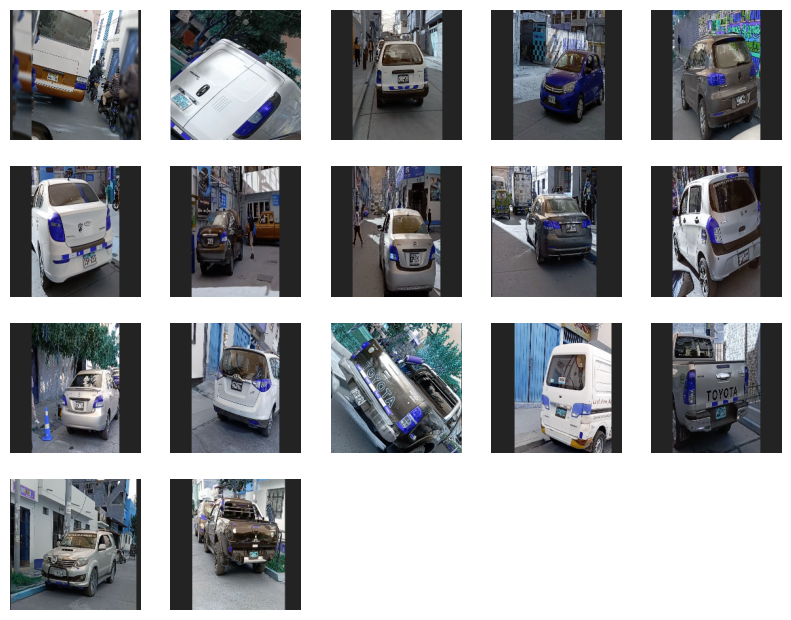

In [ ]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

Se dibuja el rectangulo de la placa usando OPENCV

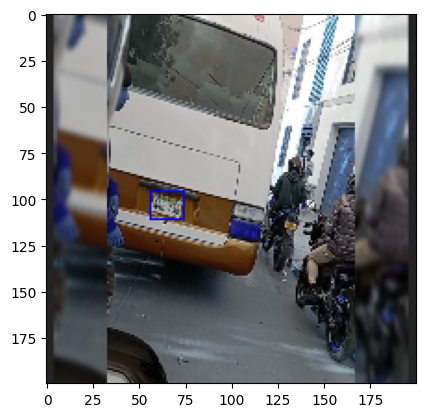

In [ ]:
#Primera imagen del dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


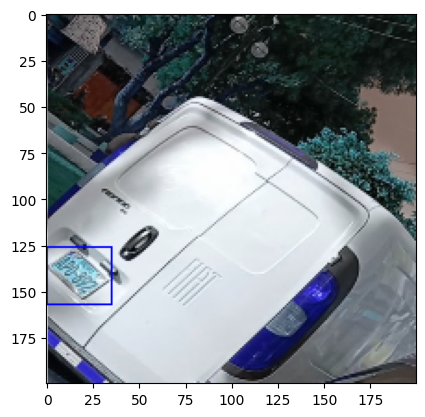

In [ ]:
#Segunda imagen del dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


Se preparan los datos para la red neuronal covolucional:

In [ ]:
#Transformando en array
X=np.array(X)
y=np.array(y)

In [ ]:
#Renormalización
X = X / 255
y = y / 255

Partimos el dataset en dos: training set/testing set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [ ]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [ ]:
# Creamos el modelo
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
15/15 [==============================] - 288s 19s/step - loss: 0.0235 - accuracy: 0.4528 - val_loss: 0.0100 - val_accuracy: 0.6792
Epoch 2/50
15/15 [==============================] - 282s 19s/step - loss: 0.0068 - accuracy: 0.7317 - val_loss: 0.0056 - val_accuracy: 0.8491
Epoch 3/50
15/15 [==============================] - 295s 20s/step - loss: 0.0034 - accuracy: 0.8302 - val_loss: 0.0043 - val_accuracy: 0.8868
Epoch 4/50
15/15 [==============================] - 323s 22s/step - loss: 0.0023 - accuracy: 0.8742 - val_loss: 0.0043 - val_accuracy: 0.8491
Epoch 5/50
15/15 [==============================] - 283s 19s/step - loss: 0.0014 - accuracy: 0.8973 - val_loss: 0.0040 - val_accuracy: 0.8868
Epoch 6/50
15/15 [==============================] - 286s 19s/step - loss: 0.0011 - accuracy: 0.9329 - val_loss: 0.0041 - val_accuracy: 0.8868
Epoch 7/50
15/15 [==============================] - 280s 19s/step - loss: 7.1070e-04 - accuracy: 0.9497 - val_loss: 0.0037 - val_accuracy: 0.9245
Ep

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 90.57%


In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

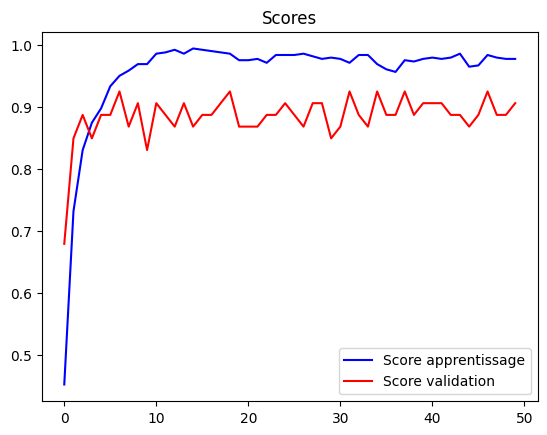

In [ ]:
plot_scores(train)

## Predicción

In [ ]:
 y_cnn = model.predict(X_test)

2/2 [==============================] - 27s 11s/step


In [ ]:
y_cnn.shape

(53, 4)

Se visualiza como el modelo identifica la posición de las placas

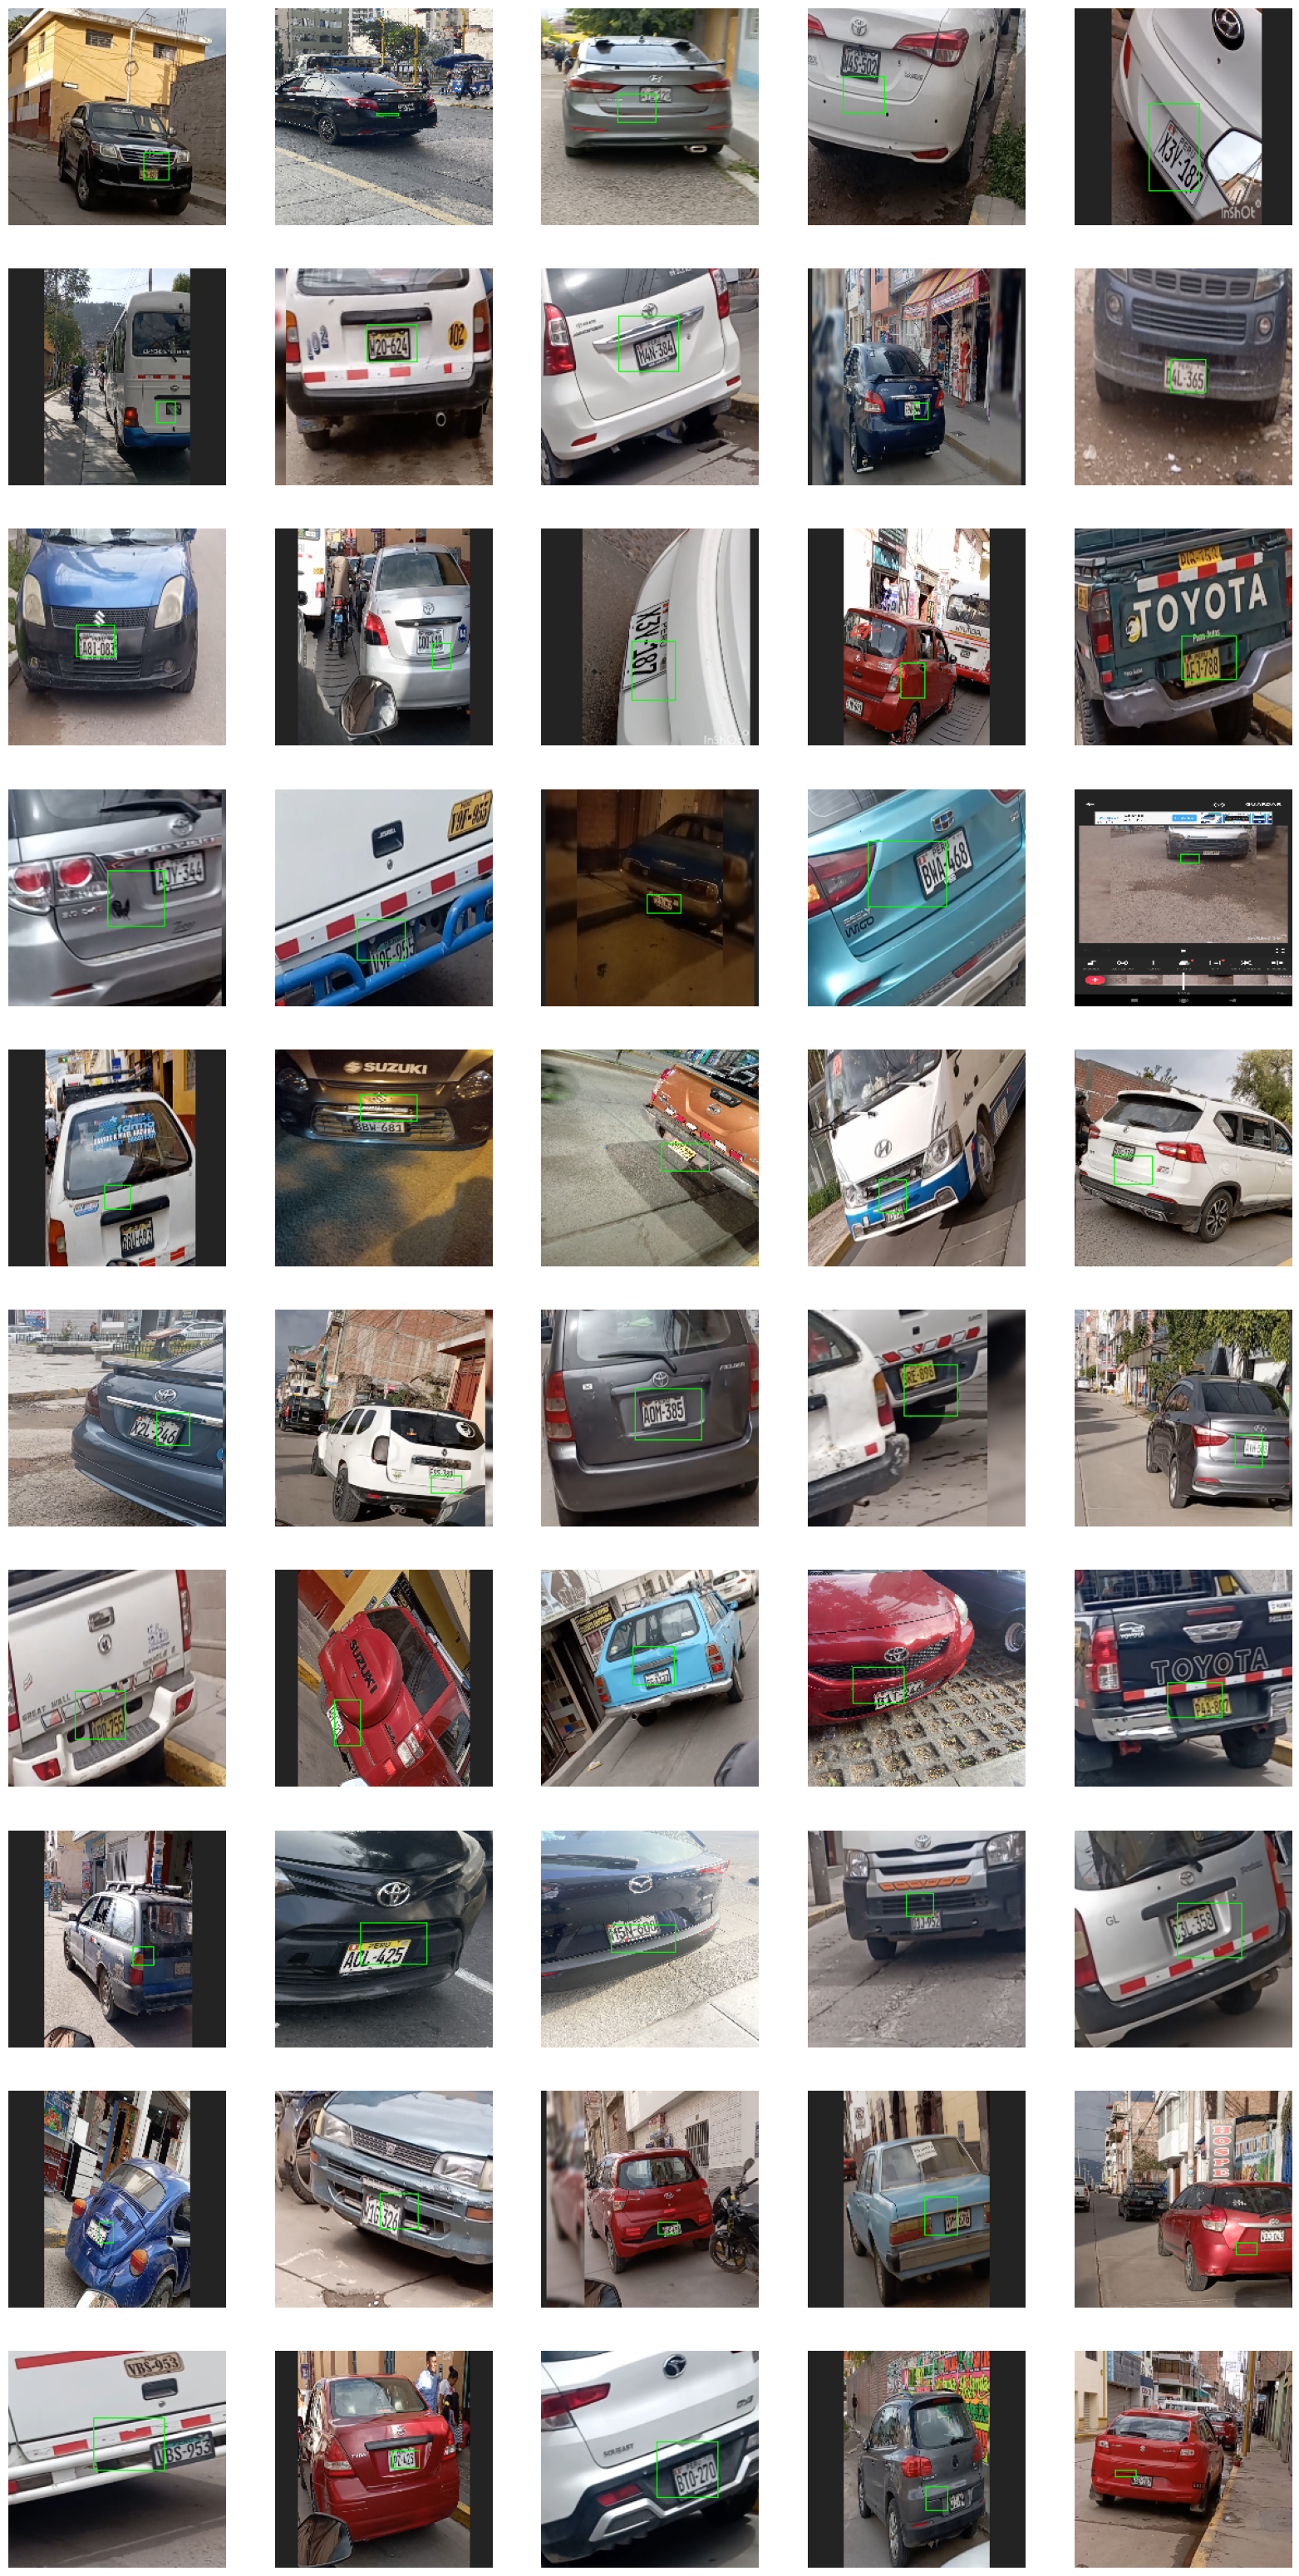

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,50) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    img_float32 = np.float32(image)
    lab_image = cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)    
    plt.imshow(lab_image)



Se guarda el model en un archivo para usarlo posteriormente

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Datasets/input2/placas.h5')